In [1]:
# Load necessary packages
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

# User-defined
from ANN_1DOF import Damped_MLP, Damped_LNN
from helpers import train_test_data, compare_sols, format_to_LNN

from jax import config
config.update("jax_enable_x64", True)

#### Generate Training Data

In [2]:
# Generate continuation data
old_train_dataset, old_test_dataset, info = train_test_data(
    save_file='data/data.pkl', 
    split_size=0.2, 
    file_name='contparameters.json', 
    min_force_amp=0.1, 
    max_force_amp=1.0, 
    num=10, 
    phase_ratio=0.5, 
    damping=0.05
)



Iter Cont     Iter Corr     Residual      Freq          Energy        Step          Beta          
0             0             1.2826e-01    0.0955        5.0861e-02                                
0             1             4.2430e-03    0.0955        1.9854e-02                                
0             2             9.4199e-07    0.0955        1.9376e-02                                
1             0             8.3037e-07    0.0955        1.9391e-02    -5.000e-03                  
1             1             5.4656e-14    0.0955        1.9392e-02    -5.000e-03    0.0022        
--------------------------------------------------------------------------------------------------
2             0             5.5065e-07    0.0956        1.9423e-02    -1.000e-02                  
2             1             5.5412e-14    0.0956        1.9423e-02    -1.000e-02    0.0044        
--------------------------------------------------------------------------------------------------
3       

#### Format Dataset for LNN Code

In [3]:
old_train_dataset['x'].shape, old_train_dataset['dx'].shape, old_train_dataset['ddx'].shape, old_train_dataset['t'].shape, old_train_dataset['f'].shape

((451978,), (451978,), (451978,), (451978,), (451978,))

In [4]:
train_dataset, test_dataset, info = format_to_LNN(old_train_dataset, old_test_dataset, info)

#### LNN Training

In [5]:
settings = {
    'name': 'ANN_LNN_Damped_Test',
    'lag_units': 64,
    'damp_units': 16,
    'layers': 3,
    'input_shape': 2,
    'train_batch_size': 128,
    'test_batch_size': 64,
    'shuffle': True,
    'seed': 0
    }

phy_sys = {
    'M': info['M'],
    'K': info['K'],
    'C': info['C'],
    'NL': info['NL'],
}

lr = 1e-03
optimizer = optax.adam(lr)
a = Damped_LNN(Damped_MLP, optimizer, settings, info, phy_sys)
a.gather()

True

In [6]:
# # Load previous results, if any
# prev_results = a.load_model('results/ANN_Damped_100epochs/model.pkl')
# results = prev_results

In [7]:
# Start training LNN
results = a.train(train_dataset, test_dataset, results=None, epochs=100, show_every=10)

Epoch: 0 | Train Loss: 50.35925672 | Best Loss: 2.38715206 | Test Loss: 2.38715206
--------------------------------------------------------------------------------------------------------
Epoch: 10 | Train Loss: 0.00001323 | Best Loss: 0.00003471 | Test Loss: 0.00004690
--------------------------------------------------------------------------------------------------------
Epoch: 20 | Train Loss: 0.00000477 | Best Loss: 0.00000387 | Test Loss: 0.00000387
--------------------------------------------------------------------------------------------------------
Epoch: 30 | Train Loss: 0.00000435 | Best Loss: 0.00000326 | Test Loss: 0.00000576
--------------------------------------------------------------------------------------------------------
Epoch: 40 | Train Loss: 0.00000365 | Best Loss: 0.00000128 | Test Loss: 0.00001146
--------------------------------------------------------------------------------------------------------
Epoch: 50 | Train Loss: 0.00000307 | Best Loss: 0.00000118 |

In [8]:
# Save results
a.save_model(results, 'results/ANN_Damped_100epochs')

('results/ANN_Damped_100epochs/model.pkl',
 'results/ANN_Damped_100epochs/metrics.pkl')

### Examine results

In [13]:
# Plotting the corresponding lagrangian and damping function for each output in the test dataset
pred_acc_damped, pred_energy_damped = a._predict(results)
q, q_d = jnp.split(test_dataset[0], 2, axis=-1)
n = 301
Lnn, Dnn = pred_energy_damped(q, q_d)

In [14]:
# Comparing accelerations
F = test_dataset[1].reshape(q.shape[0], -1)
q_dd = pred_acc_damped(test_dataset[0], F)[:, -1]

In [15]:
lim1, lim2 = info['qmax'], info['qdmax']

qa, qda = jnp.linspace(-lim1, lim1, 100), jnp.linspace(-lim2, lim2, 100)
qaa, qdaa = jnp.meshgrid(qa, qda)

# Get all energy functions here
L, D = jax.vmap(pred_energy_damped)(qaa.reshape(-1,1,1), qdaa.reshape(-1,1,1))
Lagrange_analy = 0.5*phy_sys['M']*qdaa**2 - 0.5*phy_sys['K']*qaa**2 - 0.25*phy_sys['NL']*qaa**4
Dissipation_analy = 0.5*phy_sys['C']*qdaa**2

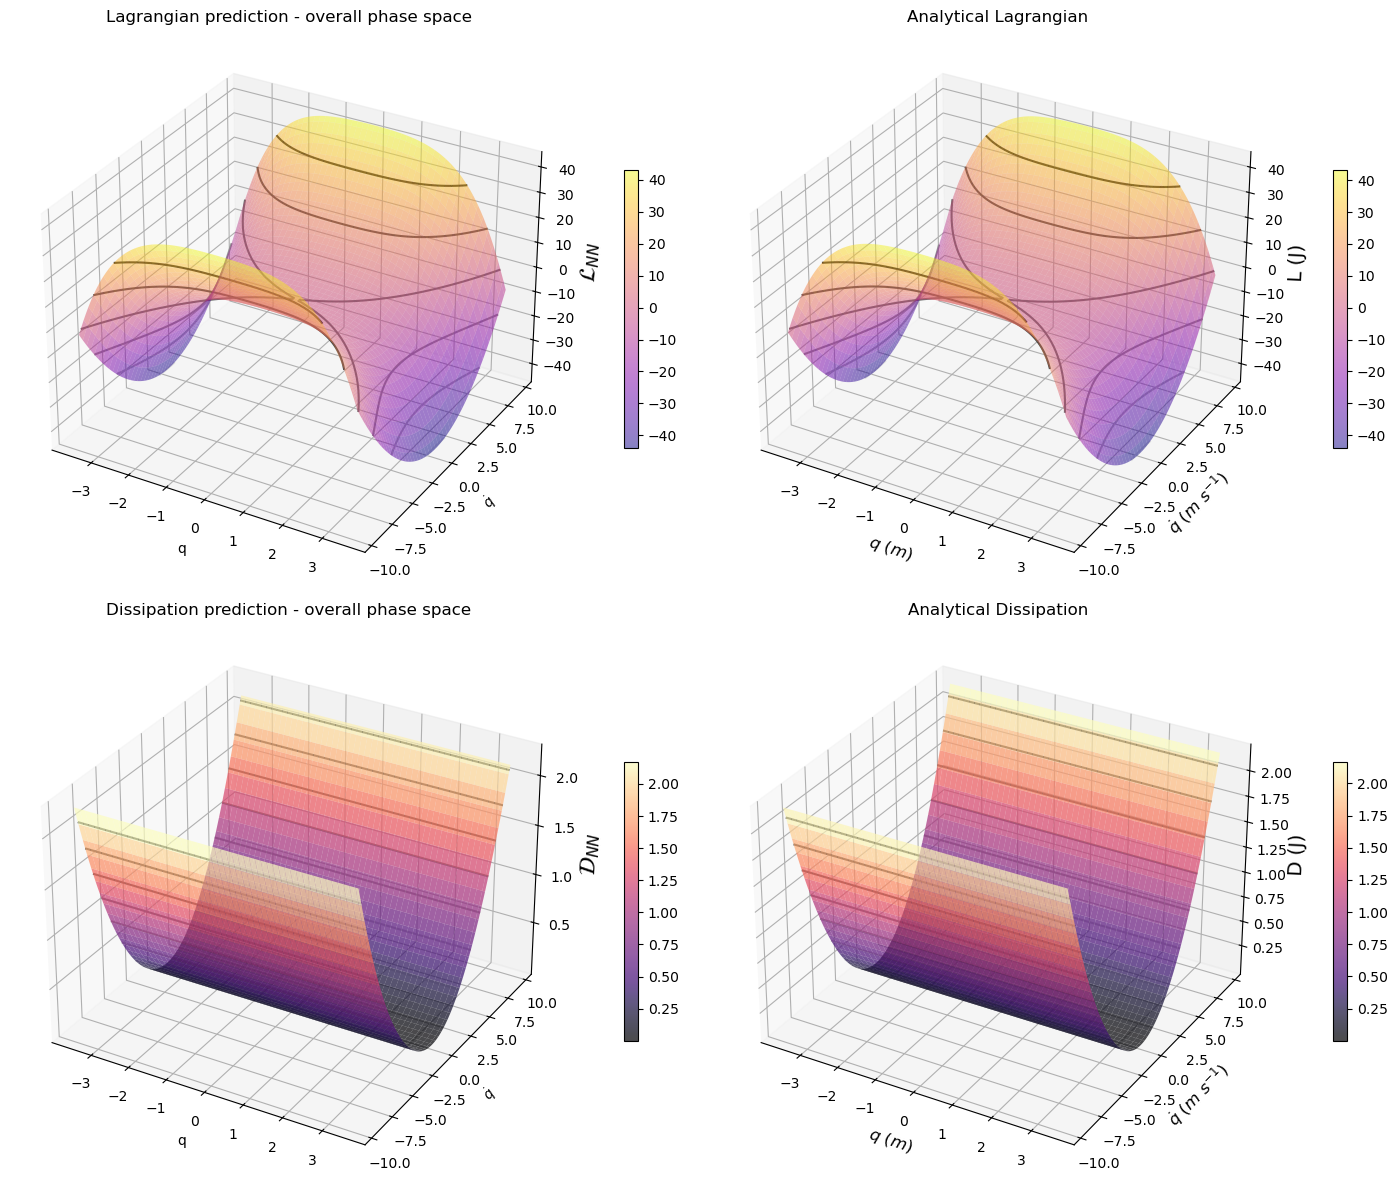

In [16]:
fig = plt.figure(figsize=(15,12), tight_layout=True)

ax = fig.add_subplot(221, projection='3d')
m = ax.plot_surface(qaa, qdaa, L.reshape(qaa.shape), alpha=0.5, cmap='plasma')
ax.contour3D(qaa, qdaa, L.reshape(qaa.shape), cmap='binary')
ax.set_xlabel('q')
ax.set_ylabel(r'$\dot{q}$')
ax.set_zlabel(r'$\mathcal{L}_{NN}$', fontsize=16, labelpad=3)
ax.set_title('Lagrangian prediction - overall phase space')
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(222, projection = '3d')
m = ax.plot_surface(qaa, qdaa, Lagrange_analy.reshape(qaa.shape), alpha=0.5, cmap='plasma')
ax.contour3D(qaa, qdaa, Lagrange_analy.reshape(qaa.shape), cmap='binary')
ax.set_title('Analytical Lagrangian')
ax.set_xlabel(r'$q \ (m)$', fontsize=12)
ax.set_ylabel(r'$\dot{q} \ (m \ s^{-1})$ ', fontsize=12)
ax.set_zlabel(r'L (J)', fontsize=14, labelpad=2)
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(223, projection='3d')
m = ax.plot_surface(qaa, qdaa, D.reshape(qaa.shape), alpha=0.7, cmap='magma')
ax.contour3D(qaa, qdaa, D.reshape(qaa.shape), cmap='binary')
ax.set_xlabel('q')
ax.set_ylabel(r'$\dot{q}$')
ax.set_zlabel(r'$\mathcal{D}_{NN}$', fontsize=16, labelpad=3)
ax.set_title('Dissipation prediction - overall phase space')
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(224, projection = '3d')
m = ax.plot_surface(qaa, qdaa, Dissipation_analy.reshape(qaa.shape), alpha=0.7, cmap='magma')
ax.contour3D(qaa, qdaa, Dissipation_analy.reshape(qaa.shape), cmap='binary')
ax.set_title('Analytical Dissipation')
ax.set_xlabel(r'$q \ (m)$', fontsize=12)
ax.set_ylabel(r'$\dot{q} \ (m \ s^{-1})$ ', fontsize=12)
ax.set_zlabel(r'D (J)', fontsize=14, labelpad=2)
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

#### Compare Analytical vs LNN FRCs

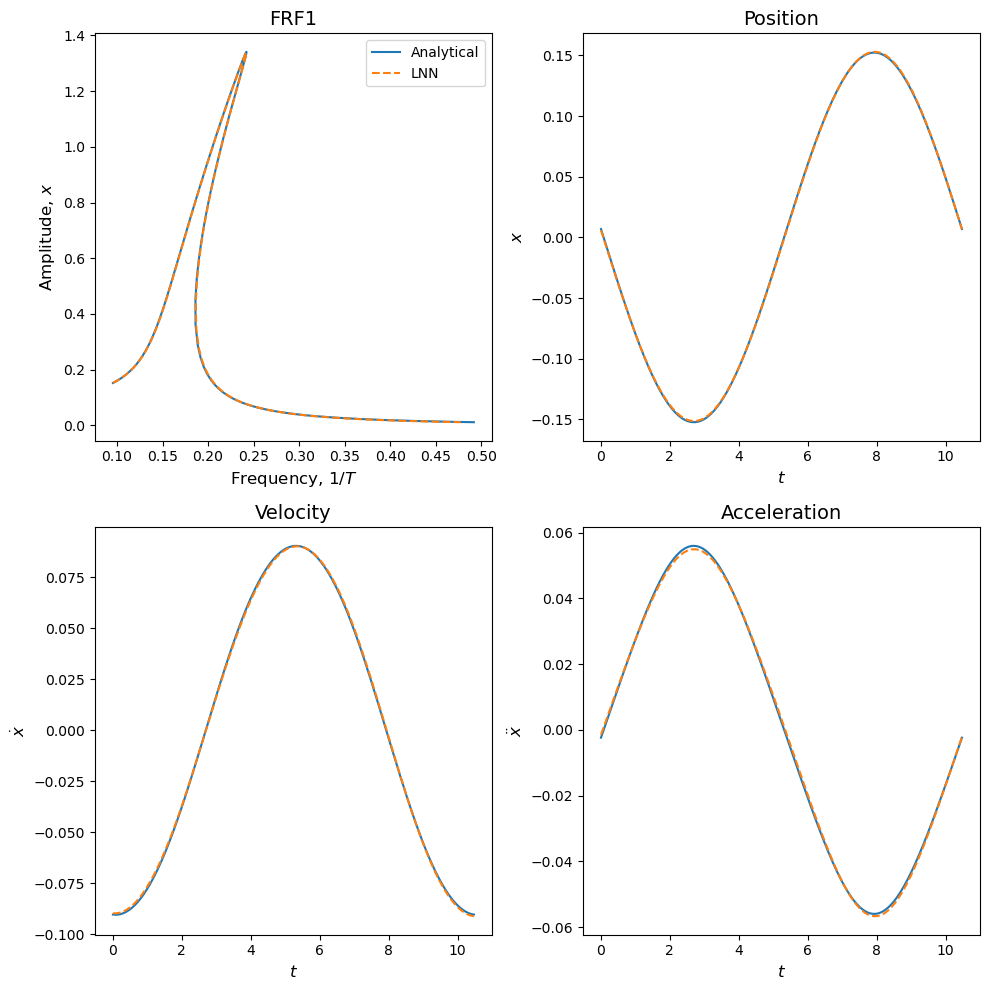

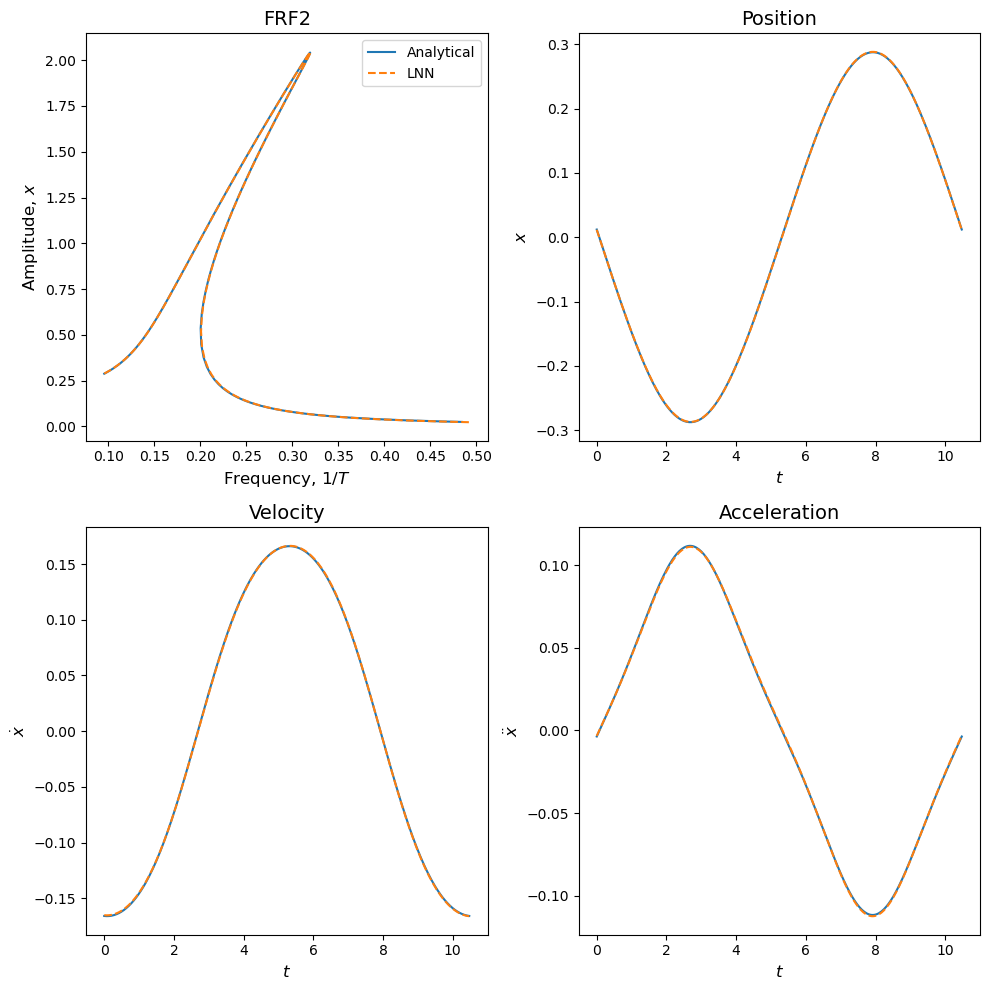

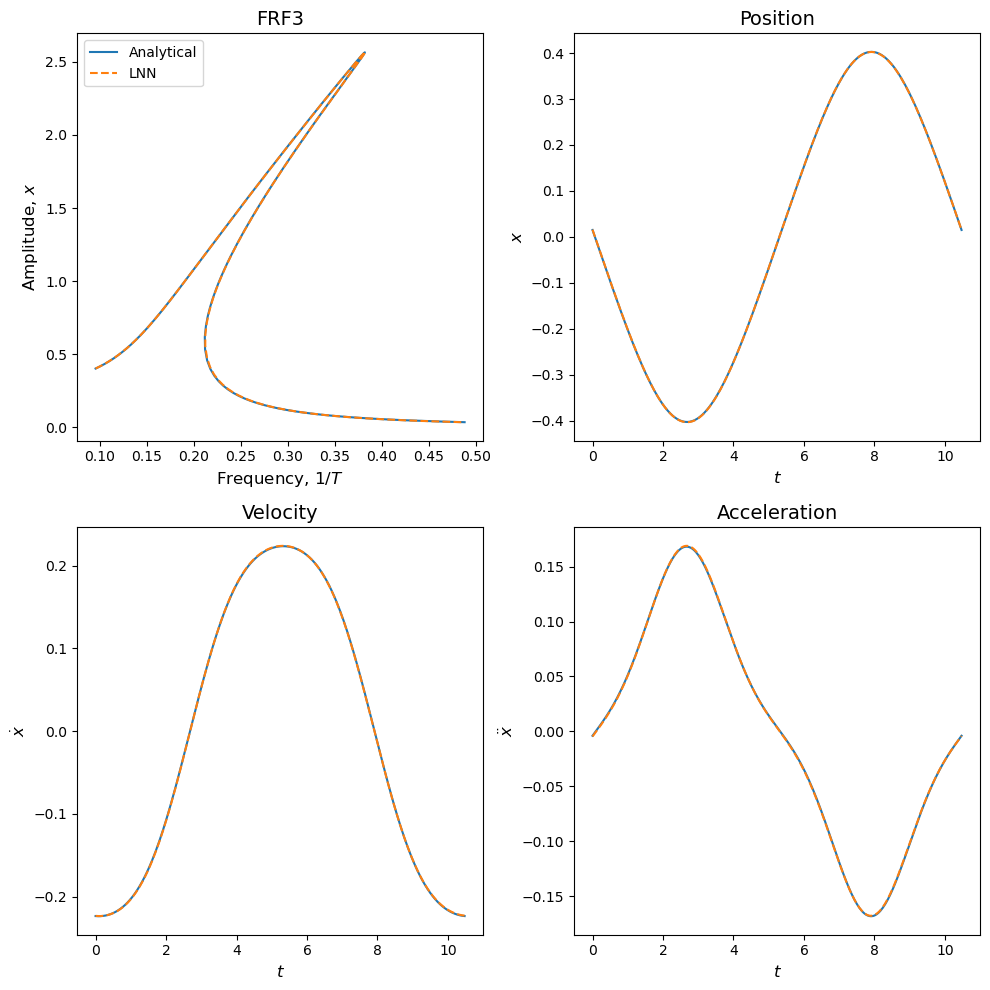

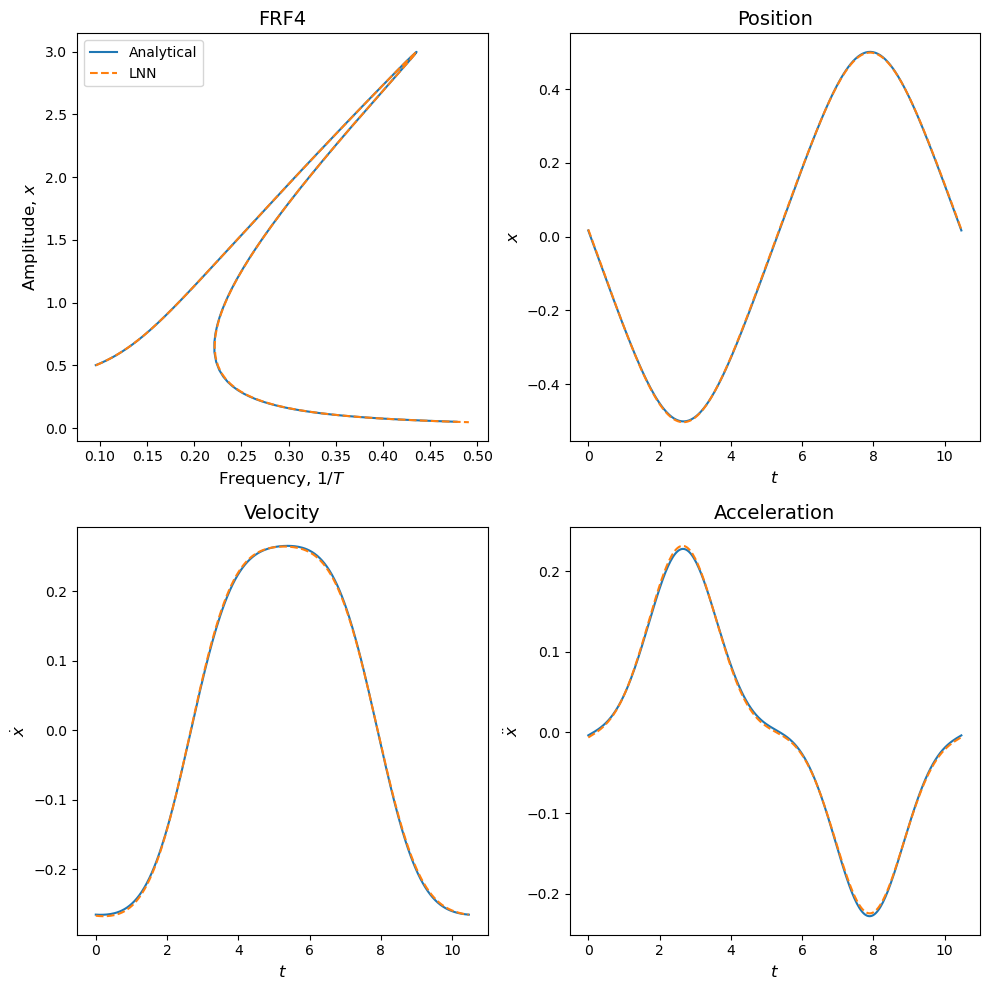

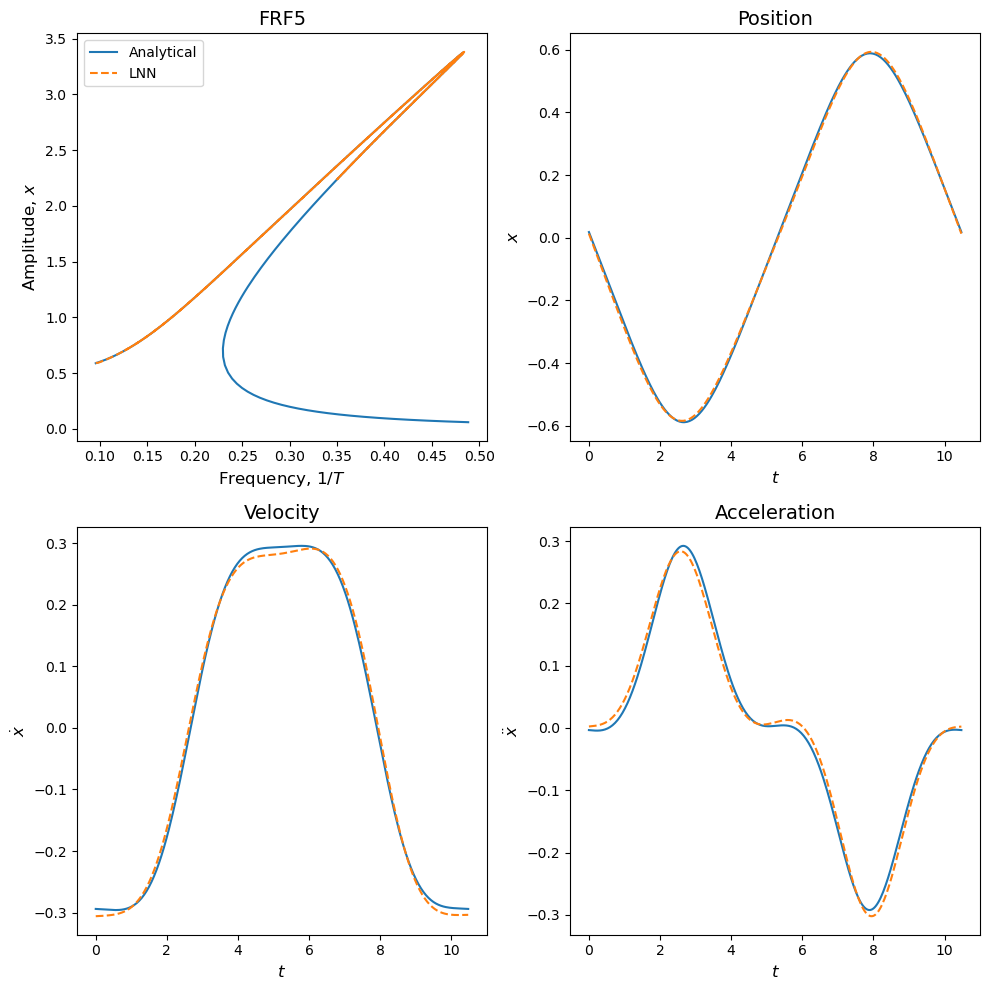

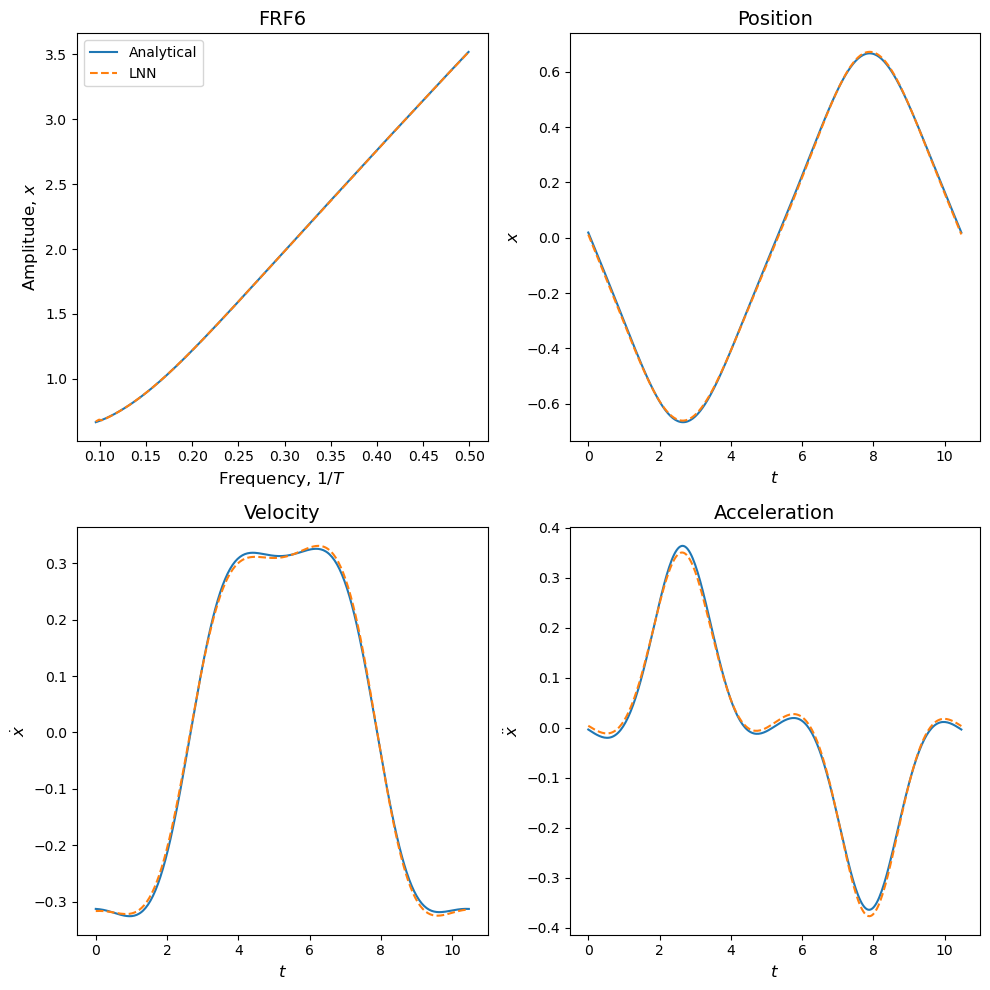

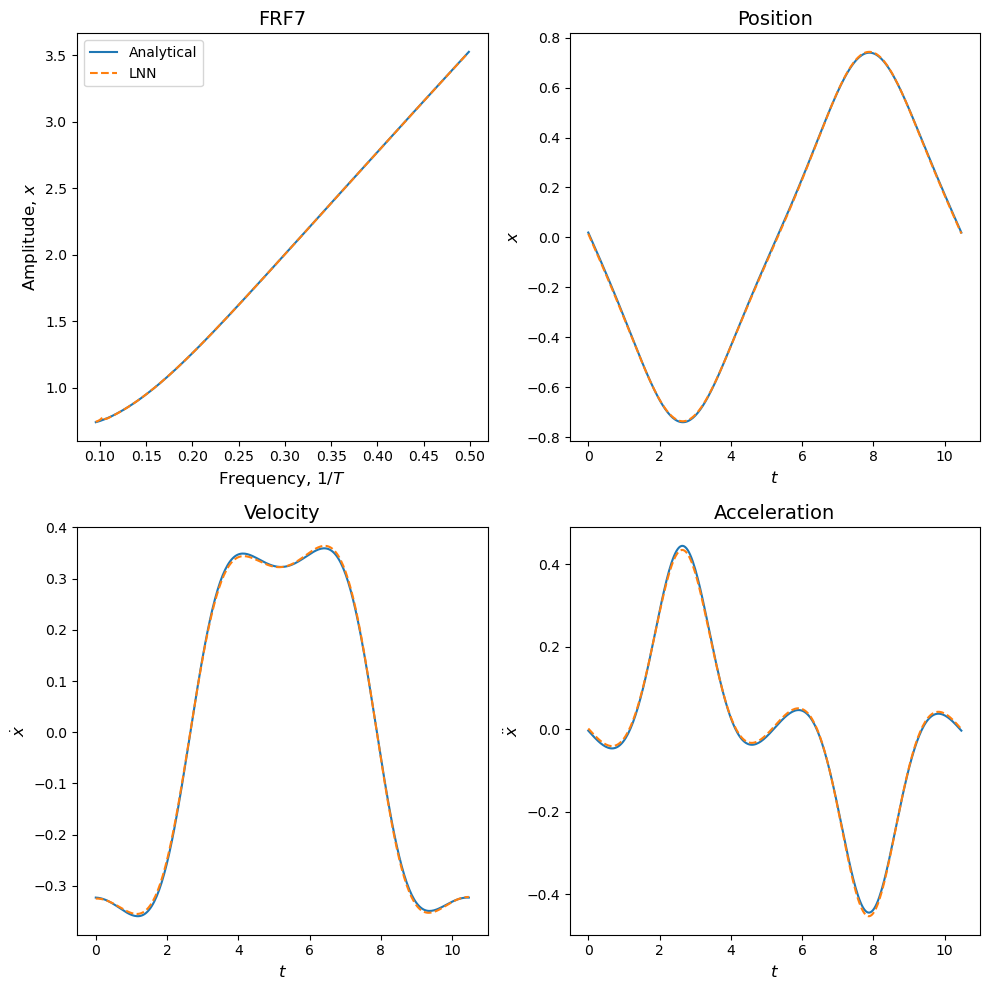

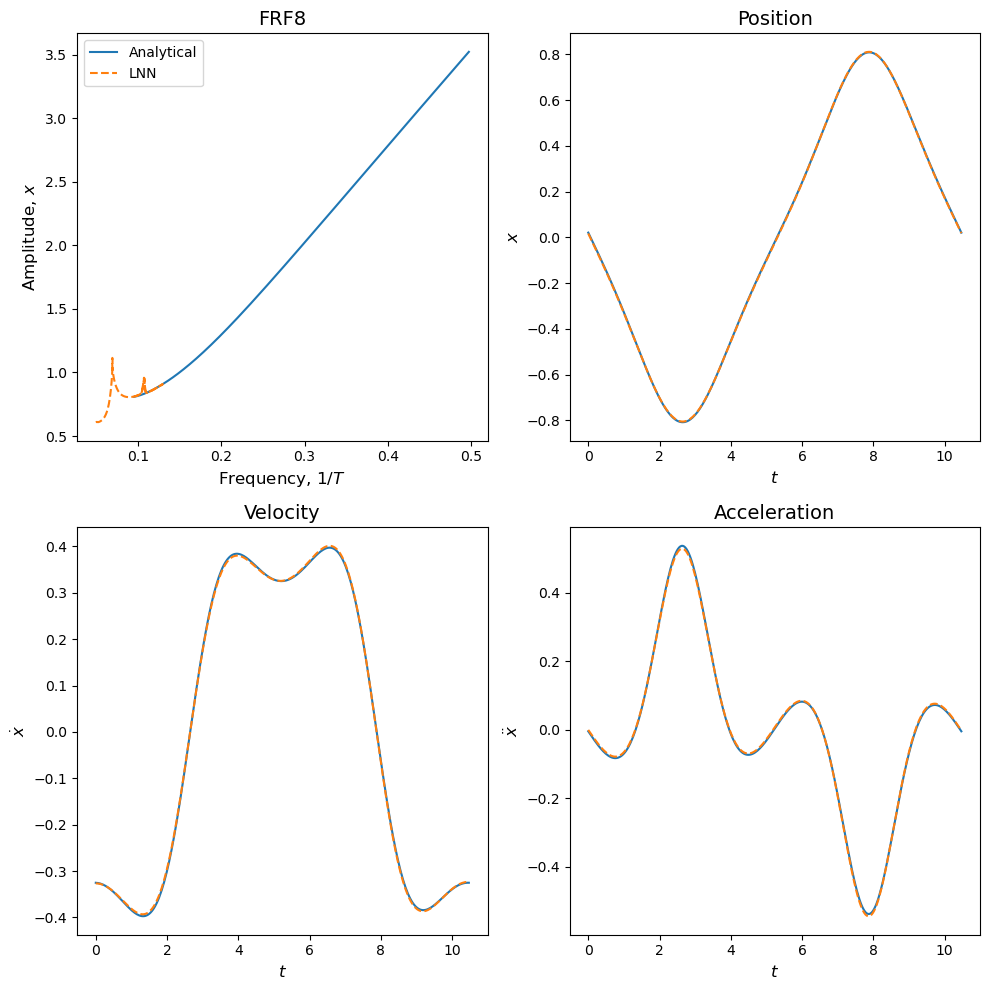

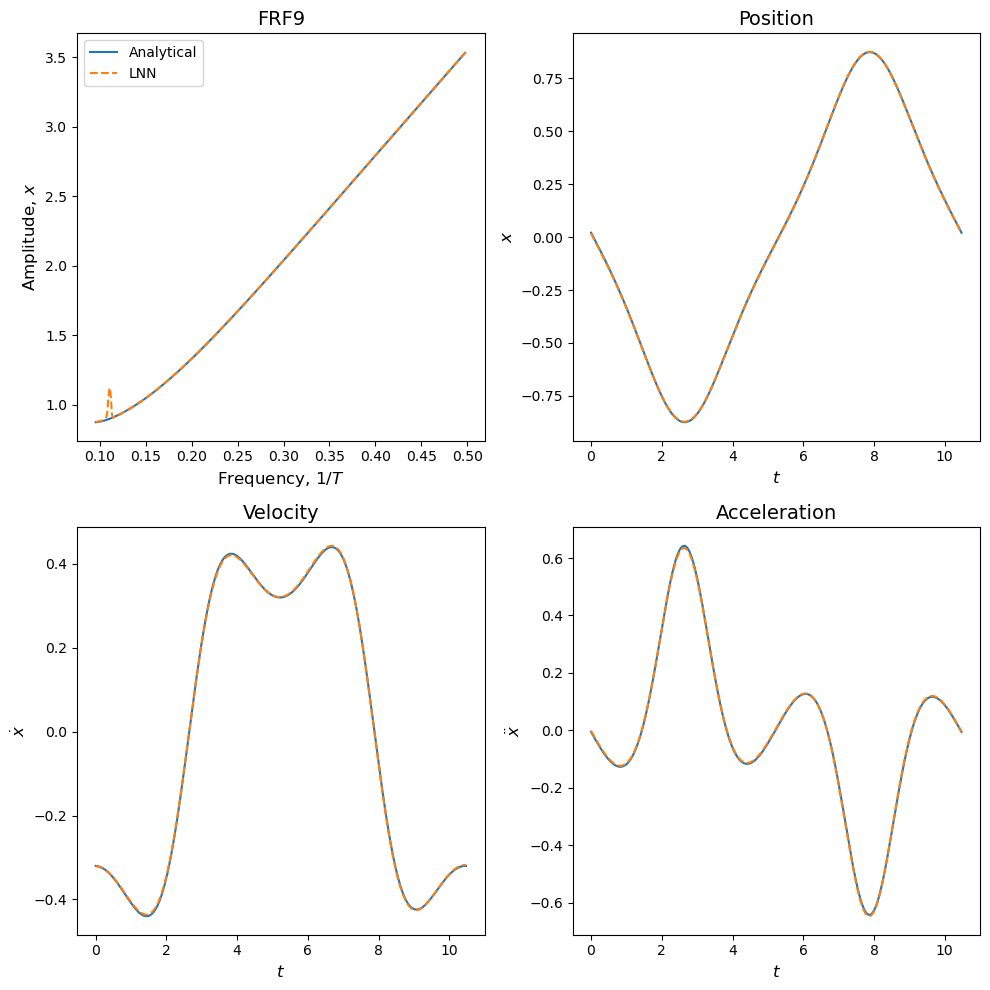

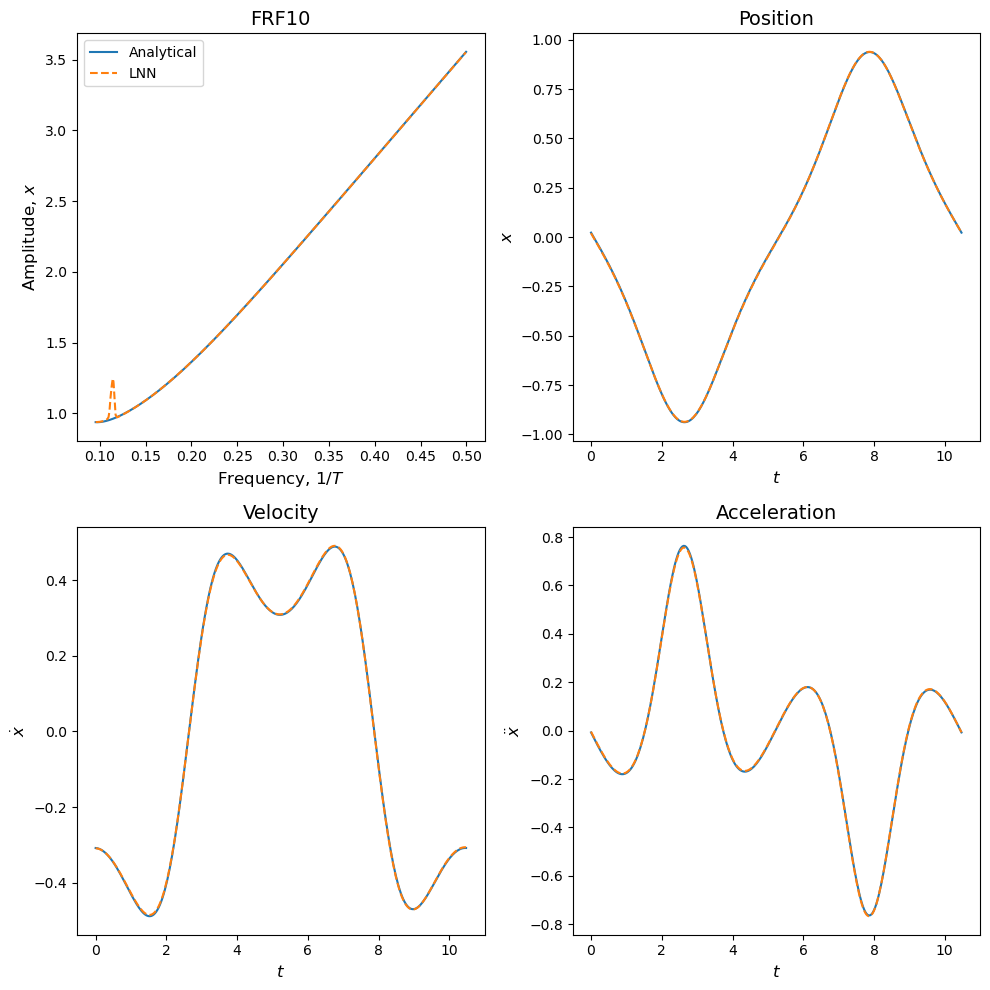

In [18]:
for i in range(1, 11, 1):
    compare_sols(anal_file=f'data_old/FRF{i}', lnn_file=f'data_LNN_old/FRF{i}')